In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy import stats
from tabulate import tabulate
import pandas as pd
import seaborn as sns
import itertools


plt.rcParams.update({'font.size': 16})

For all agents:
$$U_{BP}(a) = \alpha_{selfish} U_{selfish}(a) + \alpha_{social} U_{social}(a) + \alpha_{target} U_{target}(a)$$
$$U_{PP}(a) = U_{BP}(a) + \alpha_{reputation} U_{reputation}(a)$$ 

# The parameters for all simulations below
alpha_selfish_set = {'unselfish': 2, 'selfish': 8}

alpha_social_set = {'unsocial': 2, 'social': 8}

alpha_target = 1

alpha_reputation = we vary this

selfish_utilities = {'Not-punish': 0,
                     'Punish': we vary this}
                     
social_utilities = {'Not-punish': 0,
                    'Punish': 10}
                    
target_utilities = {'Not-punish': 0,
                    'Punish': -5}

## Audience 1: $U_{reputation}$ = P(unselfish)

This agent is the simplest agent, who gains more utility the more the audience perceives them as 'unselfish'.


In [2]:
config_name = "configs.conceptual.cost_benefit_all_audience1"
config_module = importlib.import_module(config_name)
config = config_module.get_config(0)

available_actions = {key: config[key]['available_actions'] for key in config.keys()}
alpha_selfish_set = {key: config[key]['alpha_selfish_set'] for key in config.keys()}
alpha_social_set = {key: config[key]['alpha_social_set'] for key in config.keys()}
alpha_target = {key: config[key]['alpha_target'] for key in config.keys()}
selfish_utilities = {key: config_module.get_selfish_utilities(key, available_actions[key]) for key in config.keys()}
social_utilities = {key: config_module.get_social_utilities(key, available_actions[key]) for key in config.keys()}
target_utilities = {key: config_module.get_target_utilities(key, available_actions[key]) for key in config.keys()}

# make a list of all possible agent types in the population
key = list(config.keys())[0]
permut = itertools.permutations(list(alpha_selfish_set[key].keys()), len(alpha_social_set[key]))
all_agent_types = []
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, (alpha_social_set[key].keys()))
    all_agent_types.append(list(zipped))
all_agent_types = list(itertools.chain.from_iterable(all_agent_types))
all_agent_types = sorted(all_agent_types, key=lambda x: (x[0], x[1]), reverse=True)

In [3]:
alpha_reputation_list = [0, 250, 400]
audience1_pragmatic_punisher_policy_df = pd.DataFrame({'alpha_reputation': [], 'key': [], 'action': [], 'type': [], 'policy': []})

for alpha_reputation in alpha_reputation_list:
    # for alpha_reputation in alpha_reputation_list:
    config = config_module.get_config(alpha_reputation)

    # pragmatic punisher policy
    pragmatic_punisher = {}
    for key in config.keys():
        pragmatic_punisher[key] = config[key]['pragmatic_punisher']['constructor'](**config[key]['pragmatic_punisher']['kwargs'])

    pragmatic_punisher_policy = {}
    for key in config.keys():
        pragmatic_punisher_policy[key] = {a: {} for a in available_actions[key]}
        for agent_type in all_agent_types:
            pragmatic_punisher[key].set_alpha_selfish(alpha_selfish_set[key][agent_type[0]])
            pragmatic_punisher[key].set_alpha_social(alpha_social_set[key][agent_type[1]])
            policy = pragmatic_punisher[key].policy(available_actions[key])
            for action in available_actions[key]:
                pragmatic_punisher_policy[key][action][agent_type] = policy[action]
    for key in config.keys():
        for action in available_actions[key]:
            for agent_type in all_agent_types:
                tmp_df = pd.DataFrame({'alpha_reputation': [alpha_reputation], 'key': [key], 'action': [action], 
                                       'type': [agent_type], 
                                       'policy': [pragmatic_punisher_policy[key][action][agent_type]]})
                audience1_pragmatic_punisher_policy_df = audience1_pragmatic_punisher_policy_df.append(tmp_df)

    # average policy of population of pragmatic punishers 
    average_pragmatic_punisher_policy = {}
    for key in config.keys():
        average_pragmatic_punisher_policy[key] = {a: None for a in available_actions[key]}
        for action in available_actions[key]:
            average_pragmatic_punisher_policy[key][action] = np.mean(list(pragmatic_punisher_policy[key][action].values()))

    for key in config.keys():
        for action in available_actions[key]:
            tmp_df = pd.DataFrame({'alpha_reputation': [alpha_reputation], 'key': [key], 'action': [action], 
                                   'type': ['population average'], 
                                   'policy': [average_pragmatic_punisher_policy[key][action]]})
            audience1_pragmatic_punisher_policy_df = audience1_pragmatic_punisher_policy_df.append(tmp_df)

The following plot shows the population average (over the 4 agent types) of pragmatic punisher behavior for different values of $\alpha_{reputation}$.

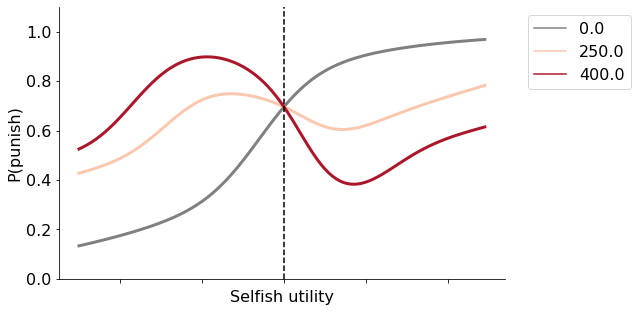

In [4]:
condition = (audience1_pragmatic_punisher_policy_df['action']=='Punish') & \
            (audience1_pragmatic_punisher_policy_df['type']=='population average')

color_palette = sns.color_palette("RdBu", 10)
palette = {0: (0.5, 0.5, 0.5), 250: color_palette[3], 400: color_palette[0]}

# sns.color_palette("crest", as_cmap=True)
plt.figure(figsize=(8, 5), facecolor='white')
ax = sns.lineplot(x='key', y='policy', hue='alpha_reputation',
             linewidth=3,
             data=audience1_pragmatic_punisher_policy_df[condition], palette=palette)
plt.vlines(x=0, ymin=0, ymax=1.1, linestyle='--', color="black")
plt.ylabel("P(punish)")
plt.ylim([0,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("")
ax.set(xticklabels=[])
plt.xlabel("Selfish utility")
plt.legend(title="", bbox_to_anchor=(1.00, 0.9, 0.3, 0.1), loc='best')

plt.savefig(f"results/concept_figures/fig2.png", dpi=1000, bbox_inches='tight')
plt.show()